# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Your code here
boston = pd.read_csv("../data/boston_data.csv")
print(boston.shape)
boston.head()

(404, 14)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


In [3]:
#Attribute Information (in order):
#   - CRIM     per capita crime rate by town
#   - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
#   - INDUS    proportion of non-retail business acres per town
#   - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
#   - NOX      nitric oxides concentration (parts per 10 million)
#   - RM       average number of rooms per dwelling
#   - AGE      proportion of owner-occupied units built prior to 1940
#   - DIS      weighted distances to five Boston employment centres
#   - RAD      index of accessibility to radial highways
#   - TAX      full-value property-tax rate per $10,000
#   - PTRATIO  pupil-teacher ratio by town
#   - B        1000(Bk - 0.63)^2 where Bk is the proportion of black people by town
#   - LSTAT    % lower status of the population
#   - MEDV     Median value of owner-occupied homes in $1000's

In [4]:
boston.dtypes

crim       float64
zn         float64
indus      float64
chas       float64
nox        float64
rm         float64
age        float64
dis        float64
rad        float64
tax        float64
ptratio    float64
black      float64
lstat      float64
medv       float64
dtype: object

In [5]:
boston.isna().sum() #no NaN

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [6]:
stats = boston.describe().transpose()
stats['IQR'] = stats['75%'] - stats['25%']
stats['outliers_low'] = (stats['25%'] - 1.5*stats['IQR'])>stats['min']
stats['outliers_up'] = (stats['75%'] + 1.5*stats['IQR'])<stats['max']
stats.transpose()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,404.0,404.0,404.0,404.0,404.0,404.0,404.0,404.0,404.0,404.0,404.0,404.0,404.0,404.0
mean,3.730912,10.509901,11.189901,0.069307,0.55671,6.30145,68.601733,3.799666,9.836634,411.688119,18.444554,355.068243,12.598936,22.312376
std,8.943922,22.053733,6.814909,0.25429,0.117321,0.67583,28.066143,2.109916,8.834741,171.073553,2.150295,94.489572,6.925173,8.837019
min,0.00632,0.0,0.46,0.0,0.392,3.561,2.9,1.1691,1.0,187.0,12.6,0.32,1.73,5.0
25%,0.082382,0.0,5.19,0.0,0.453,5.90275,45.8,2.087875,4.0,281.0,17.375,374.71,7.135,17.1
50%,0.253715,0.0,9.795,0.0,0.538,6.2305,76.6,3.20745,5.0,330.0,19.0,391.065,11.265,21.4
75%,4.053158,12.5,18.1,0.0,0.631,6.62925,94.15,5.222125,24.0,666.0,20.2,396.0075,16.91,25.0
max,88.9762,95.0,27.74,1.0,0.871,8.78,100.0,12.1265,24.0,711.0,22.0,396.9,34.37,50.0
IQR,3.970775,12.5,12.91,0.0,0.178,0.7265,48.35,3.13425,20.0,385.0,2.825,21.2975,9.775,7.9
outliers_low,False,False,False,False,False,True,False,False,False,False,True,True,False,True


In [7]:
#looking at upper outliers in different columns, unreasonable? didn't find any I want to delete, maybe just solve by rescaling?
boston["crim"].sort_values(ascending=False)
#drop every crim over 50?

380    88.97620
285    73.53410
114    67.92080
400    51.13580
116    41.52920
         ...   
30      0.01439
314     0.01381
387     0.01360
107     0.01301
367     0.00632
Name: crim, Length: 404, dtype: float64

In [8]:
boston.iloc[380:381][:]
#boston.drop(380, axis=0, inplace=True)
boston.drop([285,114,400], axis=0, inplace=True)

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

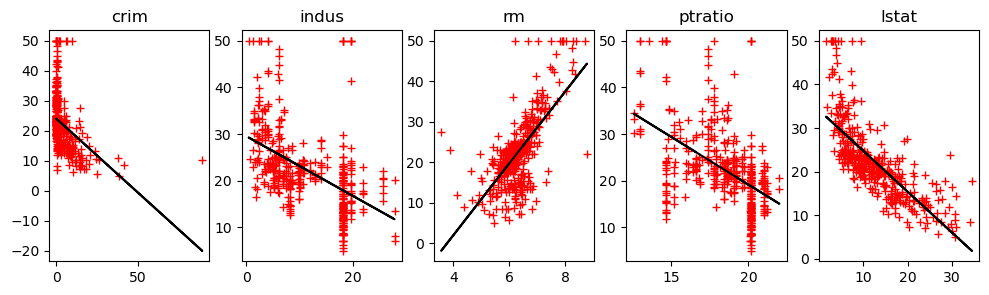

In [9]:
# Your plots here
plot_options, (chart_1, chart_2, chart_3, chart_4, chart_5) = plt.subplots(nrows=1, ncols=5, figsize=(12,3))
chart_1.plot(boston["crim"], boston["medv"], "r+")
poly1d_fn = np.poly1d(np.polyfit(boston["crim"], boston["medv"], 1)) 
chart_1.plot(boston["crim"], poly1d_fn(boston["crim"]), '-k')
chart_1.set_title("crim")
chart_2.plot(boston["indus"], boston["medv"], "r+")
poly1d_fn = np.poly1d(np.polyfit(boston["indus"], boston["medv"],1)) 
chart_2.plot(boston["indus"], poly1d_fn(boston["indus"]), '-k')
chart_2.set_title("indus")
chart_3.plot(boston["rm"], boston["medv"], "r+")
poly1d_fn = np.poly1d(np.polyfit(boston["rm"], boston["medv"], 1)) 
chart_3.plot(boston["rm"], poly1d_fn(boston["rm"]), '-k')
chart_3.set_title("rm")
chart_4.plot(boston["ptratio"], boston["medv"], "r+")
poly1d_fn = np.poly1d(np.polyfit(boston["ptratio"], boston["medv"], 1)) 
chart_4.plot(boston["ptratio"], poly1d_fn(boston["ptratio"]), '-k')
chart_4.set_title("ptratio")
chart_5.plot(boston["lstat"], boston["medv"], "r+")
poly1d_fn = np.poly1d(np.polyfit(boston["lstat"], boston["medv"], 1)) 
chart_5.plot(boston["lstat"], poly1d_fn(boston["lstat"]), '-k')
chart_5.set_title("lstat")
plt.show()

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [10]:
# Your response here
#Yes, house prices are higher with low crime rates, with less industry in the area, 
#  with a smaller pupil-teacher-ratio, with a higher status of the population.
#The only upward trend is in chart 3, house prices are higher with more rooms in the house. 
# All of these were to be expected. Linear trends seem to hold up for the lower to medium house prices.
# Trends are stronger for crime rate, room number and population status, industry does not seem to be such a good predictor.


### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

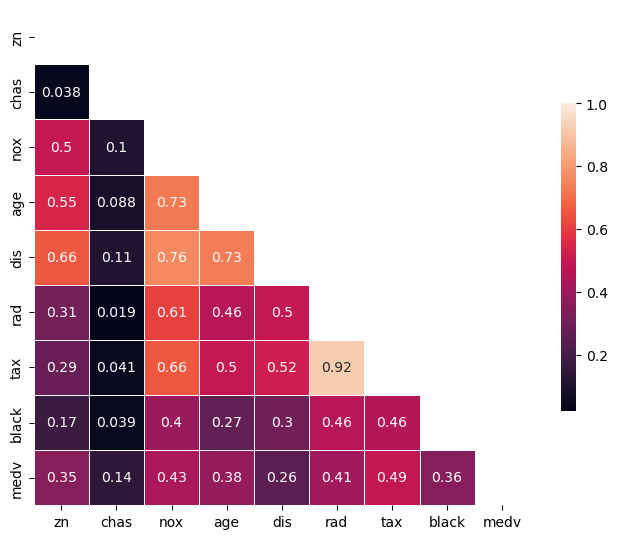

In [11]:
# Your response here
import seaborn as sn
corr=np.abs(boston[['zn', 'chas', 'nox', 'age', 'dis', 'rad', 'tax', 'black', 'medv']].corr())

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(8, 8))
cmap = sn.diverging_palette(220, 10, as_cmap=True)
sn.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)
plt.show()

In [12]:
# actually nearly every variable shows some correlation, so it is hard to pick. But there is also a lot of cross correlation.
# Tax and Rad are highly correlated, so rad could be taken out without loosing much

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [13]:
# Your code here
boston["medv"].describe()

count    401.000000
mean      22.407481
std        8.793753
min        5.000000
25%       17.200000
50%       21.500000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [14]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Your code here:
    return r2_score(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [15]:
# Your code here
from sklearn.model_selection import train_test_split

X = boston.drop(columns=["medv"], axis=1)
Y = boston["medv"]
X_train, X_test, y_train, y_test = train_test_split(X, Y)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [16]:
%%time
# Five separate RFR here with the given max depths

from sklearn.ensemble import RandomForestRegressor

forest2 = RandomForestRegressor(n_estimators=100, max_depth=2)
forest2.fit(X_train, y_train)
forest4 = RandomForestRegressor(n_estimators=100, max_depth=4)
forest4.fit(X_train, y_train)
forest6 = RandomForestRegressor(n_estimators=100, max_depth=6)
forest6.fit(X_train, y_train)
forest8 = RandomForestRegressor(n_estimators=100, max_depth=8)
forest8.fit(X_train, y_train)
forest10 = RandomForestRegressor(n_estimators=100, max_depth=10)
forest10.fit(X_train, y_train)

Wall time: 723 ms


RandomForestRegressor(max_depth=10)

Now, plot the score for each tree on the training set and on the testing set.

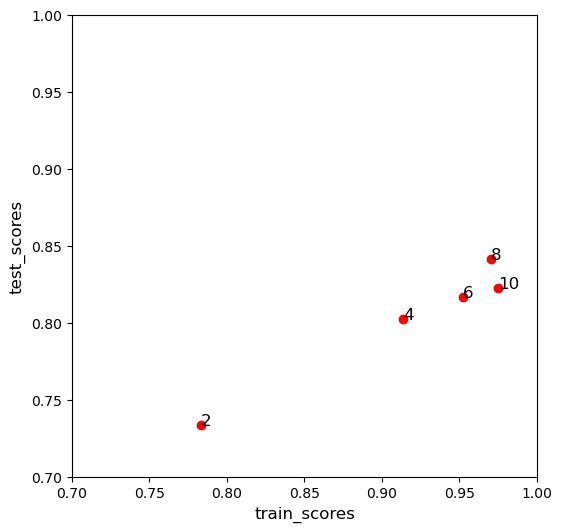

In [44]:
# Produce a plot with the score for the testing and training for the different max depths
train_scores = np.array([forest2.score(X_train, y_train),
                         forest4.score(X_train, y_train),
                         forest6.score(X_train, y_train),
                         forest8.score(X_train, y_train),
                         forest10.score(X_train, y_train)])
test_scores = np.array([forest2.score(X_test, y_test),
                        forest4.score(X_test, y_test),
                        forest6.score(X_test, y_test),
                        forest8.score(X_test, y_test),
                        forest10.score(X_test, y_test)])
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(train_scores, test_scores, "ro")
plt.xlabel("train_scores", size=12)
plt.ylabel("test_scores", size=12)
plt.xlim(0.7,1)
plt.ylim(0.7,1)
for index in range(len(train_scores)):
    ax.text(train_scores[index], test_scores[index], [2,4,6,8,10][index], size=12)
plt.show()

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [ ]:
# Your response here
# The train scores are all higher than the test scores, so there is always overfitting.
# The overfitting gets higher with higher depth of the model, max_depth = 2 has the least overfitting.

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? Check out this article before answering: https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

In [49]:
# Your response here
forest1 = RandomForestRegressor(n_estimators=100, max_depth=1)
forest1.fit(X_train, y_train)

print(f'Model with max_depth 1, train score: {forest1.score(X_train, y_train)}')
print(f'Model with max_depth 1, test score: {forest1.score(X_test, y_test)}')
print(f'Model with max_depth 10, train score: {forest10.score(X_train, y_train)}')
print(f'Model with max_depth 10, test score: {forest10.score(X_test, y_test)}')

#Model with max_depth 1: low accuracy in both, a bit overfitting but not strongly. 
# As the model was only allowed to use one split, this will have a high bias - one variable decides instead of a mix of variables.
# With the high bias probably comes a medium to high variance (because leaning to overfitting and again, only 1 variable makes the model.)
# Model 1 -> high bias.

#Model with max_depth 10: high accuracy in train, 15% lower in test, overfitting a lot. 
# As the model has up to 10 splits, the bias is probably small. But with the high variance (because of overfitting) 
# predictions can often not be accurate.
# Model 10 -> high variance.

Model with max_depth 1, train score: 0.587321041768603
Model with max_depth 1, test score: 0.5788989695692828
Model with max_depth 10, train score: 0.9747533825294609
Model with max_depth 10, test score: 0.8223244299361981


### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [54]:
%%time 

# Your response here
from sklearn.model_selection import GridSearchCV

max_depth = [3,4,5,6,7,8,9]
grid = {"max_depth":max_depth}
forest = RandomForestRegressor()

grid_search = GridSearchCV(estimator = forest, param_grid = grid, cv = 5) # cv usually 5 or 10. 5*7 = 35 runs in total
grid_search.fit(X_train,y_train)

Wall time: 3.41 s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9]})

In [55]:
# and the winner is...
grid_search.best_params_

{'max_depth': 8}

In [56]:
#ran the grid search multiple times, always a result between 7-9. So I'll choose 8.
print(f'Model with max_depth 8, train score: {forest8.score(X_train, y_train)}')
print(f'Model with max_depth 8, test score: {forest8.score(X_test, y_test)}')

# there would be many other parameters to optimise. This max-depth of 8 leads to a lot of overfitting, even though the bias is
# probably small.

Model with max_depth 8, train score: 0.9705503643566239
Model with max_depth 8, test score: 0.8409265856078486


### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [ ]:
# Your response here
# Prices changed a lot and society and neighborhoods too: with more working from home, access to highways might not be so 
# important as a good internet connection nowadays. Gentrification is a process of previously lower class quarters being 
# redeveloped, showing higher prices and a change in the population and subsequently, house prices. So no, I would not use 
# the same model on modern day data without checking closely if the same correlations still hold up.

# There is other important factors changing prices, like noise pollution from a near highway or distance to green spaces.
# But as one will never have all the factors, this is quite a varied set of factors to describe prices.

# My model was not very robust, more parameter tuning might help. To use it on other towns in the US in the 80s, I think 
# it would be robust enough then.

# In rural cities other parameters might be more important, like distance to main industrial area. Prices in rural areas are 
# normally lower (if not a vacation town), so the predictions might be very wrong.